In [1]:
import random
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from TDD.TDD import Index,TDD,Ini_TDD,get_identity_tdd,get_count,diag_matrix_2_TDD2
from TDD.TDD import diag_matrix_2_TDD,cnot_2_TDD,cont,Single_qubit_gate_2TDD,Two_qubit_gate_2TDD
from TDD.TDD_show import TDD_show,TDD_show2
import time
import datetime
import copy
import pandas as pd
from func_timeout import func_set_timeout
import func_timeout
import networkx as nx
from networkx.algorithms.approximation.treewidth import treewidth_min_degree,treewidth_min_fill_in

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\__init__.py:64: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  RuntimeWarning)


In [2]:
def is_diagonal(U):
    i, j = np.nonzero(U)
    return np.all(i == j)

def add_hyper_index(var_list,hyper_index):
    for var in var_list:
        if not var in hyper_index:
            hyper_index[var]=0
            
def add_index_2_node(var_list,node,index_2_node):
    for var in var_list:
        if not var in index_2_node:
            index_2_node[var]=set([node])
        else:
            index_2_node[var].add(node)

def add_index_set(var_list,index_set):
    for var in var_list:
        index_set.add(var)
        
def add_an_identity(qubits_index,hyper_index,node_2_index,index_2_node,index_set): 
        for k in range(len(qubits_index)):
            if qubits_index[k]!=0:
                node_2_index['q'+str(k)]=[Index('x'+str(k),0),Index('y'+str(k),hyper_index['x'+str(k)+'_'+str(qubits_index[k])])]
                add_index_2_node([index.key for index in node_2_index['q'+str(k)]],'q'+str(k),index_2_node)
            elif 'y'+str(k) in index_set:
                node_2_index['q'+str(k)]=[Index('y'+str(k),0),Index('y'+str(k),hyper_index['x'+str(k)+'_'+str(qubits_index[k])])]
                add_index_2_node([index.key for index in node_2_index['q'+str(k)]],'q'+str(k),index_2_node)
            else:
                node_2_index['q'+str(k)]=[]
                index_set.add('y'+str(k))
                index_2_node['y'+str(k)]=['q'+str(k)]        

In [3]:
#do not use hyper edge for noisy gate
def get_tensor_index(cir):
    """return the dict that link every quantum gate to the corresponding index"""

    node_2_index=dict()
    index_2_node=dict()
    index_set=set()
    hyper_index=dict()
    qubits_index = dict()
    for k in range(len(cir._qubits)):
        qubits_index[k]=0
    gates=cir.data
    for k in range(len(gates)):
        g=gates[k]
        nam=g[0].name
        q = [q.index for q in g[1]]
        gate_qubits=len(q)
        if nam=='cx':
            var_con='x'+ str(q[0])+'_'+str(qubits_index[q[0]])
            var_tar_in='x'+ str(q[1])+'_'+str(qubits_index[q[1]])
            var_tar_out='x'+ str(q[1])+'_'+str(qubits_index[q[1]]+1)
            add_hyper_index([var_con,var_tar_in,var_tar_out],hyper_index)  
            node_2_index[k]=[Index(var_con,hyper_index[var_con]),Index(var_con,hyper_index[var_con]+1),Index(var_con,hyper_index[var_con]+2),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
            hyper_index[var_con]+=2
            qubits_index[q[1]]+=1
            add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
            add_index_set([index.key for index in node_2_index[k]],index_set)   
            continue
            
        if gate_qubits==1:
            q=q[0]
            var_in='x'+ str(q)+'_'+str(qubits_index[q])
            var_out='x'+ str(q)+'_'+str(qubits_index[q]+1)
            add_hyper_index([var_in,var_out],hyper_index)
            u_matrix=Operator(g[0]).data
            if is_diagonal(u_matrix):
                node_2_index[k]=[Index(var_in,hyper_index[var_in]),Index(var_in,hyper_index[var_in]+1)]
                hyper_index[var_in]+=1
                index_set.add(var_in)
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
            else:
                node_2_index[k]=[Index(var_in,hyper_index[var_in]),Index(var_out,hyper_index[var_out])]
                qubits_index[q]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
        if gate_qubits==2:
            var_con_in='x'+ str(q[0])+'_'+str(qubits_index[q[0]])
            var_con_out='x'+ str(q[0])+'_'+str(qubits_index[q[0]]+1)
            var_tar_in='x'+ str(q[1])+'_'+str(qubits_index[q[1]])
            var_tar_out='x'+ str(q[1])+'_'+str(qubits_index[q[1]]+1)
            add_hyper_index([var_con_in,var_con_out,var_tar_in,var_tar_out],hyper_index)
            u_matrix=Operator(g[0]).data
            if is_diagonal(u_matrix):
                node_2_index[k]=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_in,hyper_index[var_con_in]+1),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_in,hyper_index[var_tar_in]+1)]
                hyper_index[var_con_in]+=1
                hyper_index[var_tar_in]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue
            else:
                node_2_index[k]=[Index(var_con_in,hyper_index[var_con_in]),Index(var_con_out,hyper_index[var_con_out]),Index(var_tar_in,hyper_index[var_tar_in]),Index(var_tar_out,hyper_index[var_tar_out])]
                qubits_index[q[0]]+=1
                qubits_index[q[1]]+=1
                add_index_2_node([index.key for index in node_2_index[k]],k,index_2_node)
                add_index_set([index.key for index in node_2_index[k]],index_set)
                continue

    for k in range(len(cir._qubits)):
        last1='x'+str(k)+'_'+str(qubits_index[k])
        new1='y'+str(k)
        last2='x'+str(k)+'_'+str(0)
        new2='x'+str(k)
        if qubits_index[k]!=0:
            index_set.remove(last1)
            index_set.add(new1)
            index_set.remove(last2)
            index_set.add(new2)
            index_2_node[new1]=index_2_node[last1]
            index_2_node[new2]=index_2_node[last2]
            index_2_node.pop(last1)
            index_2_node.pop(last2)
        elif last1 in index_set:
            index_set.remove(last1)
            index_set.add(new1)
            index_2_node[new1]=index_2_node[last1]
            index_2_node.pop(last1)
        for m in node_2_index:
            node_2_index[m]=[Index(new1,item.idx) if item.key ==last1 else item for item in node_2_index[m]]
            node_2_index[m]=[Index(new2,item.idx) if item.key ==last2 else item for item in node_2_index[m]]
    
    add_an_identity(qubits_index,hyper_index,node_2_index,index_2_node,index_set)
    return node_2_index,index_2_node,index_set

In [4]:
def get_tree_decomposition(cir,index_set,index_2_node,node_2_index):
    lin_graph=nx.Graph()
    lin_graph.add_nodes_from(index_set)

    for k in node_2_index:
        for k1 in range(len(node_2_index[k])):
            for k2 in range(k1+1,len(node_2_index[k])):
                if node_2_index[k][k1].key!=node_2_index[k][k2].key:
                    lin_graph.add_edge(node_2_index[k][k1].key,node_2_index[k][k2].key)
        
    tree_width,de_graph=treewidth_min_fill_in(lin_graph)
#     print('The treewidth is',tree_width)
    return de_graph,tree_width

In [5]:
def find_contraction_index(tree_decomposition):
    idx=None
    if len(tree_decomposition.nodes)==1:
        nod=[k for k in tree_decomposition.nodes][0]
        if len(nod)!=0:
            idx=[idx for idx in nod][0]
            nod_temp=set(nod)
            nod_temp.remove(idx)
            tree_decomposition.add_node(frozenset(nod_temp))
            tree_decomposition.remove_node(nod)
        return idx
    nod=0
    for k in tree_decomposition.nodes:
        if nx.degree(tree_decomposition)[k]==1:
            nod=k
            break
            
    neib=[k for k in tree_decomposition.neighbors(nod)][0]
    for k in nod:
        if not k in neib:
            idx=k
            break
    if idx:     
        nod_temp=set(nod)
        nod_temp.remove(idx)
        tree_decomposition.remove_node(nod)
        if frozenset(nod_temp)!=neib:
            tree_decomposition.add_node(frozenset(nod_temp))
            tree_decomposition.add_edge(frozenset(nod_temp),neib)
        return idx
    else:
        tree_decomposition.remove_node(nod)
        return find_contraction_index(tree_decomposition)

In [6]:
def contract_an_index(cir,cont_index,index_2_node,node_2_index,computed_tdd_list):
    temp_tdd,max_node_num = get_tdd_of_a_part_circuit(cir,index_2_node[cont_index],node_2_index)
    
    for node in index_2_node[cont_index]:
        for idx in node_2_index[node]:
            if idx.key!=cont_index:
                if node in index_2_node[idx.key]:
                    index_2_node[idx.key].remove(node)
                    
    index_2_node.pop(cont_index)
        
    temp_computed_tdd_list = []
    for tdd in computed_tdd_list:
        tdd_idx_out=[k.key for k in tdd.index_set]

        if cont_index in tdd_idx_out:
            temp_tdd=cont(tdd,temp_tdd)
#             max_node_num = max(max_node_num,temp_tdd.node_number())
        else:
            temp_computed_tdd_list.append(tdd)
            
    temp_computed_tdd_list.append(temp_tdd)
    computed_tdd_list = temp_computed_tdd_list

    return computed_tdd_list,max_node_num

In [7]:
def get_tdd(gate,index_list):
    """get the TDD of a quantum gate"""
    nam=gate[0].name
    u_matrix=Operator(gate[0]).data
    q = [q.index for q in gate[1]]
    gate_qubits=len(q)
    if gate_qubits ==1:
        if is_diagonal(u_matrix):
            return diag_matrix_2_TDD(u_matrix,index_list)
        else:
            return Single_qubit_gate_2TDD(u_matrix,index_list)
    if nam =='cx':
            return cnot_2_TDD(index_list,case=1)
    if gate_qubits ==2:
        if is_diagonal(u_matrix):
            return diag_matrix_2_TDD2(u_matrix,index_list)
        else:
            return Two_qubit_gate_2TDD(u_matrix,index_list)        

In [8]:
def get_tdd_of_a_part_circuit(cir,involve_nodes,node_2_index):
    """get the TDD of a part circuit"""
    tdd=get_identity_tdd()
    max_node_num = 0
    
    gates=cir.data
    for k in involve_nodes:
        if isinstance(k,str) and k[0]=='q':
            if len(node_2_index[k])==0:
                temp_tdd=get_identity_tdd()
                temp_tdd.weight=2
            elif node_2_index[k][0].key!=node_2_index[k][1].key:
                temp_tdd=Single_qubit_gate_2TDD(np.eye(2),node_2_index[k])
            else:
                temp_tdd=diag_matrix_2_TDD(np.eye(2),node_2_index[k])
        else:
            temp_tdd=get_tdd(gates[k],node_2_index[k])
        tdd=cont(tdd,temp_tdd)
#         max_node_num=max(max_node_num,tdd.node_number())
    return tdd,max_node_num

In [9]:
@func_set_timeout(1800)
def Simulation_with_tree_decomposition(cir, ini_tdd=True):
    """Simulate a circuit with TDD;
    cir is a qiskit quantum circuit;
    return the result tdd and other corresponding information
    """
    if ini_tdd:
        max_idx=len(cir.data)
        var_order=[]
        for k in range(len(cir._qubits)-1,-1,-1):
            q_idx='x'+str(k)
            var_order.append(q_idx)
            for k1 in range(max_idx):
                q_idx='x'+str(k)+'_'+str(k1)
                var_order.append(q_idx)
            q_idx='y'+str(k)
            var_order.append(q_idx)
        Ini_TDD(var_order)

    max_node_num = 0

    tdd = get_identity_tdd()
    
    node_2_index,index_2_node,index_set = get_tensor_index(cir)

    decom_tree,tree_width=get_tree_decomposition(cir,index_set,index_2_node,node_2_index)

    cont_index = find_contraction_index(decom_tree)
    computed_tdd_list=[]
    while cont_index:
        computed_tdd_list,node_num1 = contract_an_index(cir,cont_index,index_2_node,node_2_index,computed_tdd_list)
#         max_node_num=max(max_node_num,node_num1)
        cont_index=find_contraction_index(decom_tree)
            
    for temp_tdd in computed_tdd_list:
        tdd=cont(tdd,temp_tdd)
#         max_node_num=max(max_node_num,tdd.node_number())
    return tdd,max_node_num,tree_width

In [10]:
def get_error_position(gate_num, noisy_gate_num = 0):
    if noisy_gate_num == 0:
        noisy_gate_num = np.random.randint(1, min(15, gate_num))
    return random.sample(range(gate_num), noisy_gate_num)

def noisy_model(p,model=-1):
    if model==-1:
        model = random.randint(1,3)
    if model == 1:#bit flip
        E0=np.sqrt(1-p)*np.eye(2)
        E1=np.sqrt(p)*np.array([[0,1],[1,0]])
        M=np.kron(E0,E0)+np.kron(E1,E1)
        return model,[E0,E1],M
    if model == 2:#phase flip
        E0=np.sqrt(1-p)*np.eye(2)
        E1=np.sqrt(p)*np.array([[1,0],[0,-1]])
        M=np.kron(E0,E0)+np.kron(E1,E1)
        return model,[E0,E1],M
    if model == 3:#phase flip
        E0 = np.sqrt(1-p)*np.eye(2)
        E1 = np.sqrt(p/3)*np.array([[0,1],[1,0]])
        E2 = np.sqrt(p/3)*np.array([[0,-1j],[1j,0]])
        E3 = np.sqrt(p/3)*np.array([[1,0],[0,-1]])
        M=np.kron(E0,E0)+np.kron(E1,E1)+np.kron(E2,E2.conjugate())+np.kron(E3,E3)
        return model,[E0,E1,E2,E3],M

In [11]:
def get_noisy_cir(cir,error_pos,p):
    qubits=len(cir._qubits)
    noisy_cir=QuantumCircuit(2*qubits)
    model,error_model,M=noisy_model(p,model=3)
    for k in range(len(cir.data)):
        gate=cir.data[k]
        nam=gate[0].name
        q = [q.index for q in gate[1]]
        if nam=='cx':
            noisy_cir.cx(q[0],q[1])
            noisy_cir.cx(q[0]+qubits,q[1]+qubits)
        else:
            U=Operator(gate[0]).data
            noisy_cir.unitary(U,q)
            q2=[q1+qubits for q1 in q]
            noisy_cir.unitary(U.conjugate(),q2)
        if k in error_pos:
            q=np.random.randint(0,qubits)
            noisy_cir.unitary(np.eye(4),[q,q+qubits],label='noisy')
            noisy_cir.data[-1][0].params=[M]
    return noisy_cir

def get_miter_cir(noisy_cir,cir):
    qubits=len(cir._qubits)
    miter_cir=noisy_cir.copy()
    temp_cir=cir.inverse()
    for k in range(len(temp_cir.data)):
        gate=temp_cir.data[k]
        nam=gate[0].name
        q = [q.index for q in gate[1]]
        if nam=='cx':
            miter_cir.cx(q[0],q[1])
            miter_cir.cx(q[0]+qubits,q[1]+qubits)
        else:
            U=Operator(gate[0]).data
            miter_cir.unitary(U,q)
            q2=[q1+qubits for q1 in q]
            miter_cir.unitary(U.conjugate(),q2) 
    return miter_cir

In [12]:
#计算一个电路的真实比特数与门数
def get_real_qubit_num(cir):
    gates=cir.data
    q=0
    for k in range(len(gates)):
        q=max(q,max([qbit.index for qbit in gates[k][1]]))
    return q+1

def get_gates_number(cir):
    return len(cir.data)

circuit: quantum_volume_n9_d5_i0.qasm
qubits: 9
gates number: 200
run_time: 11.420562982559204
tree_width: 19
max_node_num: 0
final_node_num: 1
The trace is: (254358.30586439767+0.00031735819356981665j)
The fidelity is: 0.9702999338699252


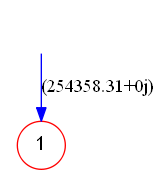

In [13]:
#Create a circuit and do simulation
path='Benchmarks/'
file_name="quantum_volume_n9_d5_i0.qasm"

cir=QuantumCircuit.from_qasm_file(path+file_name)

print('circuit:',file_name)
num_qubit=get_real_qubit_num(cir)
print('qubits:',num_qubit)
print('gates number:',get_gates_number(cir))

error_num=3

error_pos=get_error_position(len(cir.data), error_num)
# error_pos=[140, 44, 204, 144, 60]

noisy_cir=get_noisy_cir(cir,error_pos,0.01)

miter_cir=get_miter_cir(noisy_cir,cir)

t_start = time.time()
tdd,max_node_num,tree_width=Simulation_with_tree_decomposition(miter_cir)
run_time=time.time()-t_start
print('run_time:',run_time)
print('tree_width:',tree_width)
print('max_node_num:',max_node_num)
print('final_node_num:',tdd.node_number())
the_trace = tdd.weight
print('The trace is:', the_trace)
d = 2 ** num_qubit
print('The fidelity is:', abs(the_trace) / d ** 2)
TDD_show2(tdd)